In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,roc_curve,precision_recall_curve,auc,roc_auc_score
import itertools
from itertools import cycle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
model =load_model('C:/Users/Alexandru Neagu/Exercises/Face_emotion_recognition/Code for dissertation/ResNet101V2/Checkpoint_Resnet101V2-V10/Model.h5')

In [4]:
validation_data_dir = 'D:/University 3rd year/Dissertation/Code/Testing_data_c'
test_datagen = ImageDataGenerator(rescale=1./255
                                 )

test_set = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False,
        batch_size=128)
test_set.class_indices


Found 3500 images belonging to 7 classes.


{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [5]:

actual_emotion_name=[]
actual_emotion_array=[]
emotion_name=[ 'Anger','Disgust','Fear', 'Happy', 'Neutral','Sad', 'Surprise']
emotion_array=[0,0,0,0,0,0,0]

filenames = test_set.filenames

for name in filenames:
   # print(name)
    actual_emotion_name.append(str(name).split("\\")[0])
    for i in range(len(emotion_name)):
            if str(name).split("\\")[0] == emotion_name[i]:                
                emotion_array[i]=1
               # print(str(name).split("\\")[0], emotion_name[i])
                actual_emotion_array.append(emotion_array)
            else:
                emotion_array=[0,0,0,0,0,0,0]
              
nb_samples = len(filenames)

In [6]:
test_set.class_indices
TrainClasses=test_set.class_indices
 
# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName
 
# Saving the face map for future reference
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)
 
# The model will give answer as a numeric tag
# This mapping will help to get the corresponding face name for it
print("Mapping of Face and its ID",ResultMap)
 
# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

 The Number of output neurons:  7


In [7]:
predict = model.predict(test_set,verbose=0)

In [8]:
print(np.argmax(predict))
prediction_name=[]
for i in range(len(predict)):
       prediction_name.append(ResultMap[np.argmax(predict[i])])
print(prediction_name[10])

11350
Anger


In [9]:
cm=confusion_matrix(actual_emotion_name, prediction_name)
cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<AxesSubplot:xlabel='Predicted %', ylabel='Actual %'>

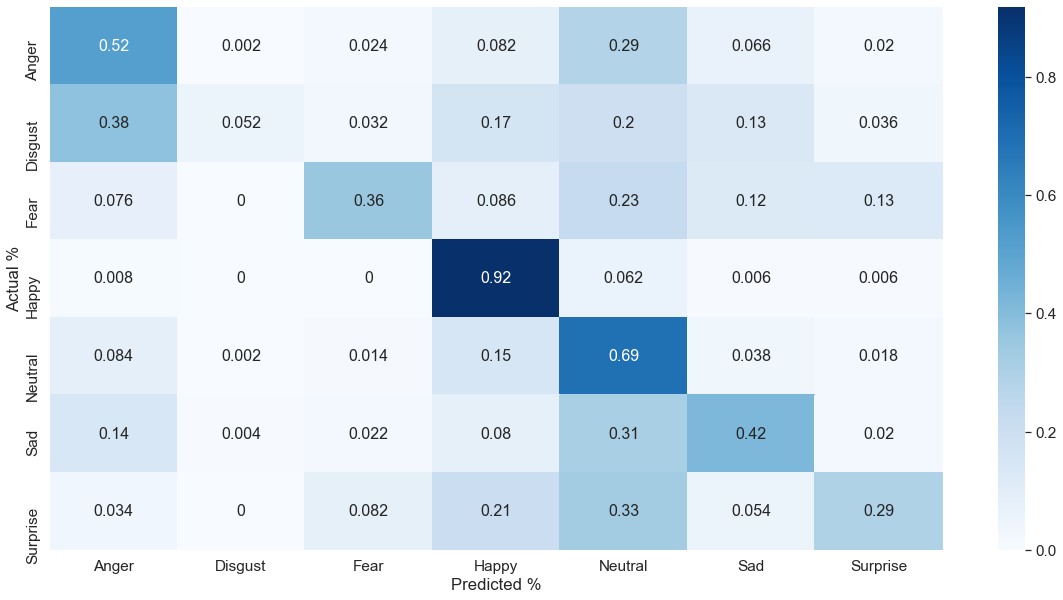

In [10]:
df_cm = pd.DataFrame(cm, columns=np.unique(emotion_name), index = np.unique(emotion_name))
df_cm.index.name = 'Actual %'
df_cm.columns.name = 'Predicted %'
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})


In [11]:
from sklearn.metrics import classification_report
print(classification_report(actual_emotion_name, prediction_name))

              precision    recall  f1-score   support

       Anger       0.42      0.52      0.46       500
     Disgust       0.87      0.05      0.10       500
        Fear       0.67      0.36      0.47       500
       Happy       0.54      0.92      0.68       500
     Neutral       0.33      0.69      0.44       500
         Sad       0.50      0.42      0.45       500
    Surprise       0.56      0.29      0.38       500

    accuracy                           0.46      3500
   macro avg       0.56      0.46      0.43      3500
weighted avg       0.56      0.46      0.43      3500



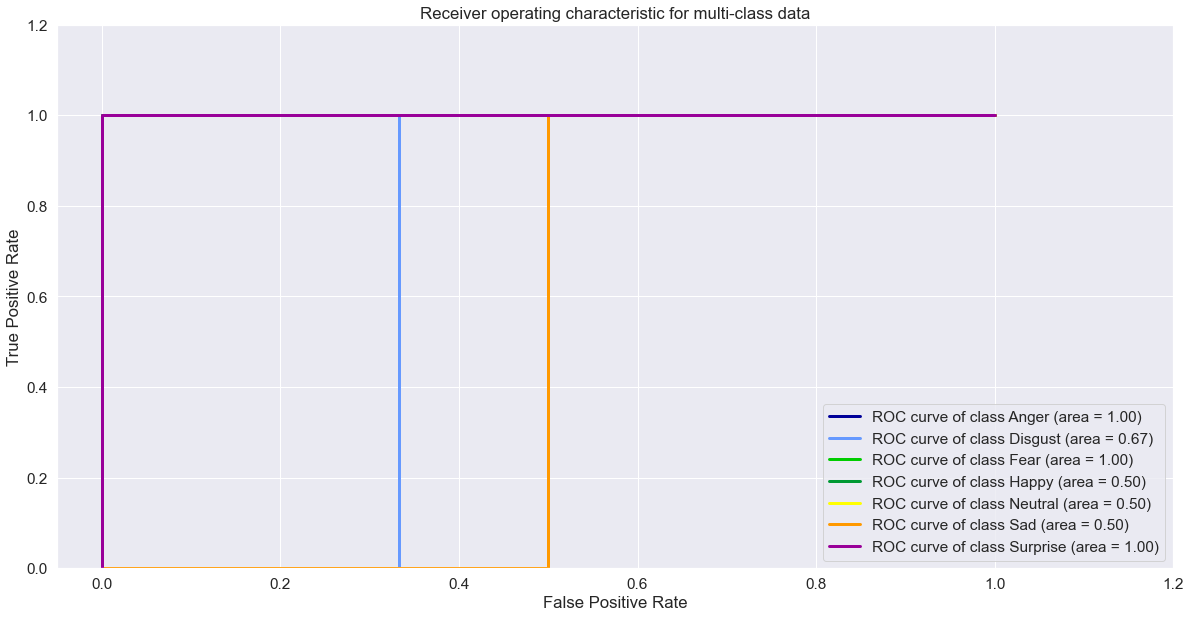

In [12]:
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(20,10))
for i in range(len(emotion_name)):
    fpr[i], tpr[i], threshold = roc_curve(actual_emotion_array[:][i], predict[:][i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['#000099', '#6699ff', '#00cc00','#009933','#ffff00','#ff9900','#990099'])
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color,lw=3,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(emotion_name[i], roc_auc[i]))


plt.xlim([-0.05, 1.2])
plt.ylim([0.0, 1.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

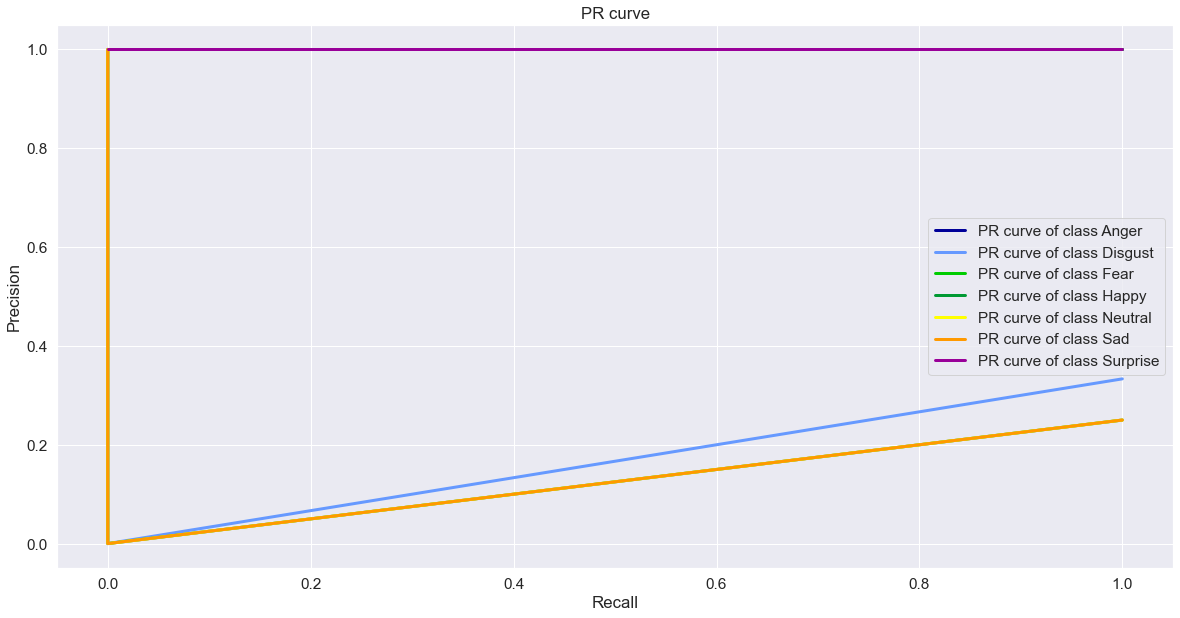

In [13]:
precision = dict()
recall = dict()
plt.figure(figsize=(20,10))
for i in range(len(emotion_name)):
    precision[i], recall[i], _= precision_recall_curve(actual_emotion_array[:][i], predict[:][i])

colors = cycle(['#000099', '#6699ff', '#00cc00','#009933','#ffff00','#ff9900','#990099'])
for i, color in zip(range(7), colors):
    plt.plot(recall[i], precision[i], color=color,lw=3,
             label='PR curve of class {0}'
             ''.format(emotion_name[i]))


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("PR curve")
plt.show()